In [1]:
%pip install selenium beautifulsoup4 nltk matplotlib wordcloud

  Using cached selenium-4.25.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/36.1 MB ? eta -:--:--
     ---------- ---------------------------- 10.0/36.1 MB 51.6 MB/s eta 0:00:01
     --------------- ----------------------- 14.4/36.1 MB 36.2 MB/s eta 0:00:01
     ----------------------- --------------- 21.8/36.1 MB 34.4 MB/s eta 0:00:01
     ----------------------------- --------- 27.5/36.1 MB 33.5 MB/s eta 0:00:01
     ----------------------------------- --- 33.3/36.1 MB 32.0 MB/s eta 0:00:01
     --------------------------------------- 36.1/36.1 MB 30.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [499 lines of output]
        Using cached setuptools_scm-8.1.0-py3-none-any.whl.metadata (6.6 kB)
        Using cached numpy-2.1.2.tar.gz (18.9 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Installing backend dependencies: started
        Installing backend dependencies: still running...
        Installing backend dependencies: finished with status 'error'
        error: subprocess-exited-with-error
      
        脳 pip subprocess to install backend dependencies did not run successfully.
        鈹\x82 exit code: 1
        鈺扳攢> [469 lines of output]
              Using cached ninja-1.11.1.1.tar.gz (132 kB)
              Installing build dependenci

In [2]:
%pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Verify NLTK resources
import nltk
nltk.data.path.append('./nltk_data')

from nltk.corpus import stopwords
print("First 10 stopwords:", stopwords.words('english')[:10])

# Verify Selenium
from selenium import webdriver
print("Selenium is working!")

# Verify Matplotlib and WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
print("Matplotlib and WordCloud are working!")


First 10 stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Selenium is working!
Matplotlib and WordCloud are working!


In [6]:
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

# Ensure NLTK data path
nltk.data.path.append('./nltk_data')

# Download necessary NLTK data if not already available
nltk.download('stopwords', download_dir='./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')

STOPWORDS = set(stopwords.words('english'))
PUNCTUATION = set(['.', ',', '!', '?', ':', ';', '-', '’', '“', '”', '…'])


[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

# Define categories and associated URLs
CATEGORIES = {
    "World": ["https://x.com/CNN", "https://x.com/Reuters"],
    "Business": ["https://x.com/WSJ", "https://x.com/federalreserve"],
    "Music": ["https://x.com/billboard", "https://x.com/rollingstone"],
    "Sports": ["https://x.com/ESPN", "https://x.com/FIFAWorldCup"],
    "Technology": ["https://x.com/verge", "https://x.com/wired"]
}

def init_driver(headless=True):
    """Initialize the Chrome WebDriver with options."""
    options = Options()
    if headless:
        options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    return webdriver.Chrome(options=options)

def scroll_and_scrape(driver, max_scrolls=10):
    """Scroll the page incrementally and scrape tweets."""
    tweets = []
    seen_texts = set()

    for _ in range(max_scrolls):
        driver.execute_script("window.scrollBy(0, 300);")
        time.sleep(1)

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        for tweet in soup.find_all('article'):
            text = tweet.find(['div', 'span'], {'data-testid': 'tweetText'})
            if text and text.get_text() not in seen_texts:
                tweets.append(text.get_text())
                seen_texts.add(text.get_text())

    return tweets

def scrape_account(url, headless=True, max_retries=5):
    """Scrape tweets from a given account."""
    driver = init_driver(headless)
    driver.get(url)

    tweets = []
    retries = 0

    while retries < max_retries and not tweets:
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, "//div[@data-testid='tweetText']"))
            )
            tweets = scroll_and_scrape(driver)
        except Exception as e:
            print(f"Retry {retries + 1}/{max_retries} - Waiting for tweets...")
            retries += 1
            time.sleep(2)

    driver.quit()

    if not tweets:
        print(f"Failed to collect tweets from {url} after {max_retries} retries.")
    else:
        print(f"Collected {len(tweets)} tweets from {url}.")
    return tweets

def select_category():
    """Let the user select a category and return the associated URLs."""
    print("Available categories:")
    for i, category in enumerate(CATEGORIES, 1):
        print(f"{i}. {category}")

    choice = int(input("Select a category by number: ")) - 1
    category_name = list(CATEGORIES.keys())[choice]
    return category_name, CATEGORIES[category_name]

if __name__ == "__main__":
    # Let the user select a category
    category, urls = select_category()
    print(f"Scraping tweets for category: {category}")

    all_tweets = []
    for url in urls:
        print(f"Scraping {url}")
        tweets = scrape_account(url, headless=True)
        all_tweets.extend(tweets)

    print(f"Total tweets collected: {len(all_tweets)}")
    print(all_tweets)

Available categories:
1. World
2. Business
3. Music
4. Sports
5. Technology
Scraping tweets for category: World
Scraping https://x.com/CNN
Retry 1/5 - Waiting for tweets...
Collected 13 tweets from https://x.com/CNN.
Scraping https://x.com/Reuters
Collected 12 tweets from https://x.com/Reuters.
Total tweets collected: 25
['Secretary of Defense Lloyd Austin says North Korea has deployed troops to Russia, the first US official to publicly confirm the development', 'The Georgia Supreme Court has upheld a block on controversial election rules passed by allies of Trump, a major victory for Democrats in the battleground state', "The CDC has issued a warning about a deadly multistate E. coli outbreak that it says is linked to McDonald's Quarter Pounders", "Denny's, a diner chain best known for never closing its doors, will shut down a tenth of its locations as it mulls a big change to its 24/7 operating hours", 'Rudy Giuliani must turn over control of his Manhattan penthouse apartment and lux

In [8]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    words = text.lower().split()
    return [word for word in words if word not in STOPWORDS and word not in PUNCTUATION]

def extract_keywords(texts, top_n=20):
    all_words = []
    for text in texts:
        all_words.extend(preprocess_text(text))
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Extract top 10 keywords from scraped tweets
keywords = extract_keywords(tweets, top_n=10)
print("Top Keywords:", keywords)


Top Keywords: [('us', 3), ('court', 3), ('trump', 3), ('says', 2), ('georgia', 2), ('supreme', 2), ('election', 2), ('cnn', 2), ('political', 2), ('federal', 2)]


Generating Word Cloud...


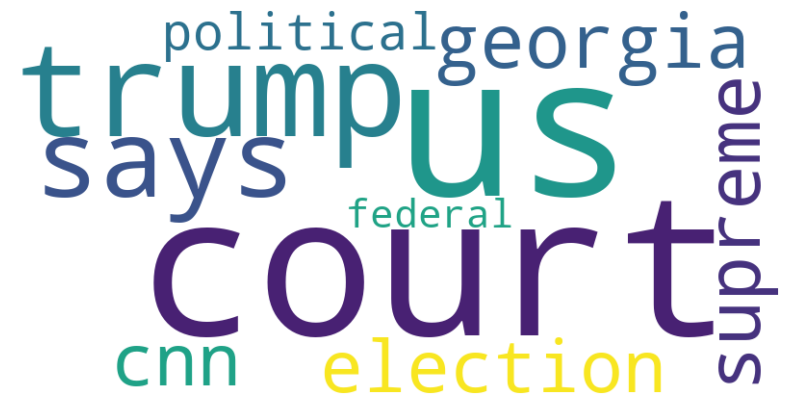

Generating Bar Plot...


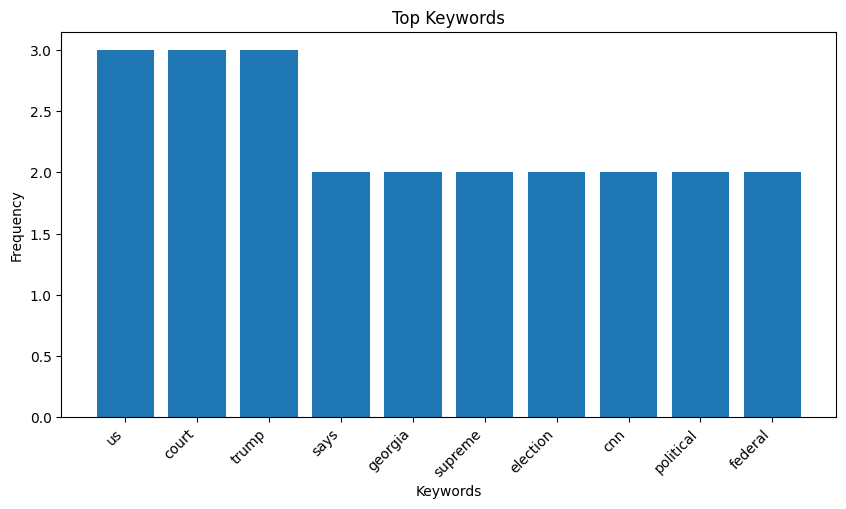

In [9]:
def generate_wordcloud(keywords):
    word_freq = {word: freq for word, freq in keywords}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def generate_bar_plot(keywords):
    words, frequencies = zip(*keywords)

    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top Keywords')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Generate visualizations
print("Generating Word Cloud...")
generate_wordcloud(keywords)

print("Generating Bar Plot...")
generate_bar_plot(keywords)
